# Sentiment Analysis with Machine Learning

## Import the necessary libraries

In [1]:
from typing import List, Dict, Tuple
from collections import Counter, defaultdict
import re
import string
import math
from tqdm.notebook import tqdm
from scipy.special import softmax
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset_builder, load_dataset, get_dataset_split_names, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('stopwords')
nltk.download('vader_lexicon')

plt.style.use('ggplot')

[nltk_data] Downloading package punkt_tab to /Users/danc/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/danc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/danc/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /Users/danc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/danc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/danc/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Check the features of the IMDb dataset, then load the dataset

In [2]:
ds_builder = load_dataset_builder("imdb")

# Inspect dataset features
ds_builder.info.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [3]:
# Load the IMDb dataset from Hugging Face
imdb = load_dataset("imdb")

In [4]:
# Check the dataset split names
get_dataset_split_names("imdb")

['train', 'test', 'unsupervised']

In [5]:
# Check the dataset
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
# Check the training dataset
ds_train = imdb['train']
ds_train

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [7]:
# Check the test dataset
ds_test = imdb['test']
ds_test

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [8]:
# Concatenate the training and test datasets so we can shuffle and split later
ds = concatenate_datasets([ds_train, ds_test])
ds

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

## Exploratory Data Analysis (EDA)

In [9]:
# Use pandas to check for missing texts and labels
df = pd.DataFrame(ds) # convert the dataset to a pandas dataframe
num_missing_texts = df['text'].isna().sum()
print(f'Number of missing texts: {num_missing_texts}')

num_missing_labels = df['label'].isna().sum()
print(f'Number of missing labels: {num_missing_labels}')

Number of missing texts: 0
Number of missing labels: 0


In [10]:
# Add a new column to the dataframe to store the word count of each text
df['length'] = df['text'].apply(lambda x: len(x.split()))
df['length'].describe()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: length, dtype: float64

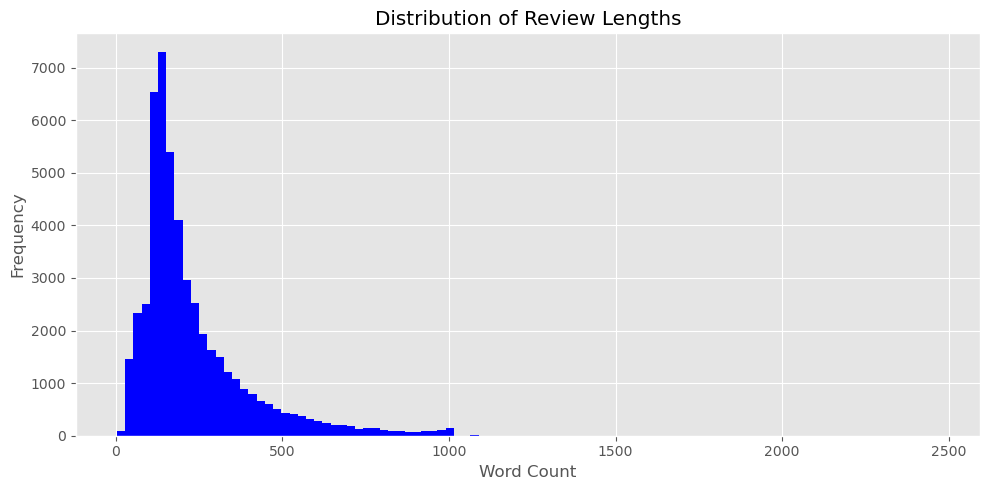

In [11]:
# Check the distribution of the review lengths (word count)
df['length'].plot(kind='hist', bins=100, figsize=(10, 5), title='Distribution of Review Lengths',\
                   xlabel='Word Count', ylabel='Frequency', color='blue')
plt.tight_layout()
plt.show()

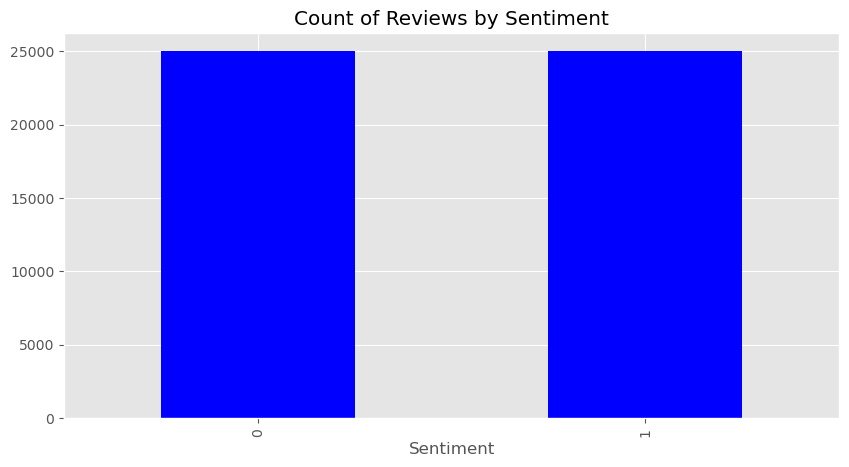

In [12]:
# Check the distribution of the sentiment labels
ax = df['label'].value_counts().sort_index() \
    .plot(kind='bar',color='blue',
          title='Count of Reviews by Sentiment',
          figsize=(10, 5))
ax.set_xlabel('Sentiment')
plt.show()

## Text Preprocessing

In [13]:
# Check the first text in the dataset
example_text = df.iloc[0]['text']
example_text

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [14]:
def preprocess_text(text: str) -> List[str]:
    """
    Preprocess the text and remove unnecessary characters and stopwords.
    
    Input:
        text (str): The input text to preprocess
        
    Output:
        List[str]: A list of tokens after tokenizing, removing stopwords & punctuation, and stemming
    """
    # remove hyperlinks
    new_text = re.sub(r'https?://[^\s\n\r]+', '', text)
    # remove hashtags
    new_text = re.sub(r'#', '', new_text)
    # remove numbers
    new_text = re.sub(r'\d+', '', new_text)
    # tokenize the text
    tokens = nltk.word_tokenize(new_text.lower())
    # collect stopwords
    stop_words = set(stopwords.words('english'))
    # set up the stemmer
    stemmer = PorterStemmer()
    # remove stopwords & punctuation, then stem the words
    tokens = [stemmer.stem(word) for word in tokens \
              if word not in stop_words and word not in string.punctuation]

    return tokens

In [15]:
# Test the preprocessing function
preprocess_text(example_text)

['rent',
 'curious-yellow',
 'video',
 'store',
 'controversi',
 'surround',
 'first',
 'releas',
 'also',
 'heard',
 'first',
 'seiz',
 'u.s.',
 'custom',
 'ever',
 'tri',
 'enter',
 'countri',
 'therefor',
 'fan',
 'film',
 'consid',
 '``',
 'controversi',
 "''",
 'realli',
 'see',
 'myself.',
 'br',
 'br',
 'plot',
 'center',
 'around',
 'young',
 'swedish',
 'drama',
 'student',
 'name',
 'lena',
 'want',
 'learn',
 'everyth',
 'life',
 'particular',
 'want',
 'focu',
 'attent',
 'make',
 'sort',
 'documentari',
 'averag',
 'swede',
 'thought',
 'certain',
 'polit',
 'issu',
 'vietnam',
 'war',
 'race',
 'issu',
 'unit',
 'state',
 'ask',
 'politician',
 'ordinari',
 'denizen',
 'stockholm',
 'opinion',
 'polit',
 'sex',
 'drama',
 'teacher',
 'classmat',
 'marri',
 'men.',
 'br',
 'br',
 'kill',
 'curious-yellow',
 'year',
 'ago',
 'consid',
 'pornograph',
 'realli',
 'sex',
 'nuditi',
 'scene',
 'far',
 'even',
 "'s",
 'shot',
 'like',
 'cheapli',
 'made',
 'porno',
 'countrymen'

In [16]:
# Apply the preprocessing function to the entire dataset
tqdm.pandas() # enable tqdm for pandas
df['tokens'] = df['text'].progress_apply(preprocess_text) # apply the preprocessing function to the text column
df

  0%|          | 0/50000 [00:00<?, ?it/s]

,text,label,length,tokens
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,288,"[rent, curious-yellow, video, store, controver..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,214,"[``, curiou, yellow, '', risibl, pretenti, ste..."
2,If only to avoid making this type of film in t...,0,93,"[avoid, make, type, film, futur, film, interes..."
3,This film was probably inspired by Godard's Ma...,0,118,"[film, probabl, inspir, godard, 's, masculin, ..."
4,"Oh, brother...after hearing about this ridicul...",0,311,"[oh, brother, ..., hear, ridicul, film, umptee..."
...,...,...,...,...
49995,Just got around to seeing Monster Man yesterda...,1,744,"[got, around, see, monster, man, yesterday, lo..."
49996,I got this as part of a competition prize. I w...,1,116,"[got, part, competit, prize, watch, realli, ex..."
49997,I got Monster Man in a box set of three films ...,1,212,"[got, monster, man, box, set, three, film, mai..."
49998,"Five minutes in, i started to feel how naff th...",1,380,"[five, minut, start, feel, naff, look, 've, go..."


In [17]:
# Add a new column to the dataframe to store the token counts of each text
df['token_count'] = df['tokens'].apply(len)
df['token_count'].describe()

count    50000.000000
mean       129.270060
std         97.772709
min          3.000000
25%         69.000000
50%         96.000000
75%        158.000000
max       1474.000000
Name: token_count, dtype: float64

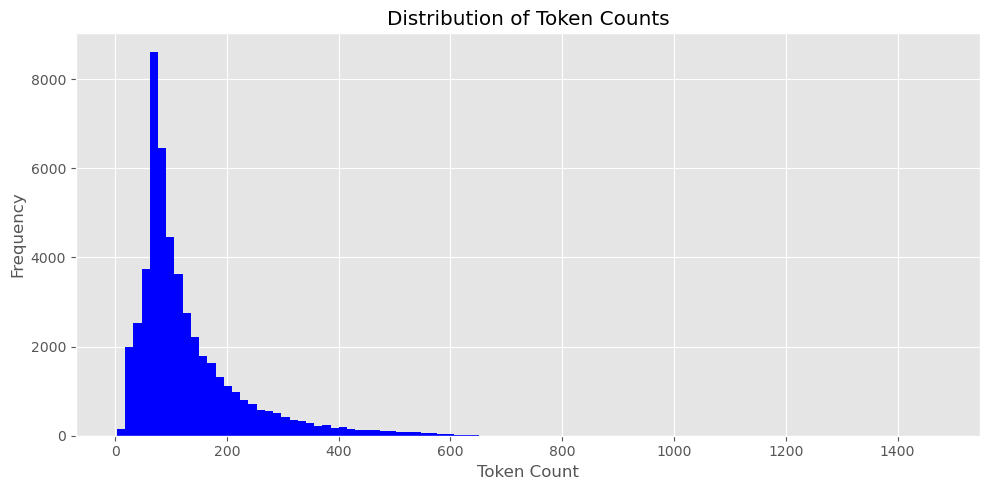

In [18]:
# Check the distribution of the token counts
df['token_count'].plot(kind='hist', bins=100, figsize=(10, 5), title='Distribution of Token Counts',\
                       xlabel='Token Count', ylabel='Frequency', color='blue')
plt.tight_layout()
plt.show()

### Build a dictionary of (token,label) frequencies

In [19]:
# Build a dictionary of (token, label) frequencies
token_freqs = defaultdict(int)
for row in df.itertuples(index=True): # iterate over rows
    for token in row.tokens: # iterate over tokens per row
        token_freqs[(token, row.label)] += 1

token_freqs

defaultdict(int,
            {('rent', 0): 1702,
             ('curious-yellow', 0): 3,
             ('video', 0): 1939,
             ('store', 0): 663,
             ('controversi', 0): 162,
             ('surround', 0): 334,
             ('first', 0): 8221,
             ('releas', 0): 1484,
             ('also', 0): 7146,
             ('heard', 0): 1090,
             ('seiz', 0): 20,
             ('u.s.', 0): 156,
             ('custom', 0): 98,
             ('ever', 0): 6420,
             ('tri', 0): 7568,
             ('enter', 0): 413,
             ('countri', 0): 817,
             ('therefor', 0): 352,
             ('fan', 0): 3086,
             ('film', 0): 43363,
             ('consid', 0): 1531,
             ('``', 0): 34765,
             ("''", 0): 33916,
             ('realli', 0): 12311,
             ('see', 0): 12987,
             ('myself.', 0): 15,
             ('br', 0): 103991,
             ('plot', 0): 8282,
             ('center', 0): 332,
             ('around', 0): 

### Feature Extraction

In [20]:
# Define a function to extract token,label features from a list of tokens
def extract_features(tokens: List[str], token_freqs: Dict[Tuple[str, int], int]) -> np.ndarray:
    """
    Extract token,label features from a list of tokens.
    
    Input: 
        tokens: a list containing tokens from a text
        token_freqs: a dictionary corresponding to the frequencies of each tuple (token, label)
    Output: 
        x: a feature vector of dimension (1,2)
    """
    # Initialize the feature vector
    x = np.zeros((1, 2))

    # Iterate over the tokens and update the feature vector
    for token in tokens:
        # increment the token count for the positive label 1
        x[0,0] += token_freqs.get((token,1), 0)
        # increment the token count for the negative label 0
        x[0,1] += token_freqs.get((token,0), 0)

    return x


In [21]:
# Apply the feature extraction function to the entire dataset
tl_features = np.concatenate([extract_features(tokens, token_freqs) for tokens in df['tokens']])
df[['tlc_pos','tlc_neg']] = tl_features
df.head()


,text,label,length,tokens,token_count,tlc_pos,tlc_neg
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,288,"[rent, curious-yellow, video, store, controver...",156,1327072.0,1381838.0
1,"""I Am Curious: Yellow"" is a risible and preten...",0,214,"[``, curiou, yellow, '', risibl, pretenti, ste...",128,866369.0,902966.0
2,If only to avoid making this type of film in t...,0,93,"[avoid, make, type, film, futur, film, interes...",57,1126385.0,1129952.0
3,This film was probably inspired by Godard's Ma...,0,118,"[film, probabl, inspir, godard, 's, masculin, ...",64,1010603.0,1019495.0
4,"Oh, brother...after hearing about this ridicul...",0,311,"[oh, brother, ..., hear, ridicul, film, umptee...",202,2681263.0,2787723.0


## Model Building

### Shuffle and split the dataset

In [22]:
# Shuffle the dataset
shuffled_df = df.sample(frac=1, random_state=12).reset_index(drop=True)
shuffled_df.head()


,text,label,length,tokens,token_count,tlc_pos,tlc_neg
0,Sorry to say but was disappointed in the film....,0,393,"[sorri, say, disappoint, film, rush, suppos, u...",183,2010961.0,2311519.0
1,Oh what a condescending movie! Set in Los Ange...,0,329,"[oh, condescend, movi, set, lo, angel, center,...",203,2431312.0,2559489.0
2,Given the history of the director of this movi...,0,268,"[given, histori, director, movi, hard, believ,...",129,1094161.0,1332895.0
3,This film takes what could have been a good id...,0,130,"[film, take, could, good, idea, mummifi, year,...",66,702456.0,755662.0
4,I just recently discovered this fantastic seri...,1,141,"[recent, discov, fantast, seri, ca, n't, seem,...",91,1184869.0,1216493.0


In [23]:
# Split the dataset into training and test sets
df_train = shuffled_df.iloc[:40000]
df_test = shuffled_df.iloc[40000:50000]

#df_train.head()
#df_test.head()

,text,label,length,tokens,token_count,tlc_pos,tlc_neg
40000,"You can call this one a flop, and that's a ver...",0,743,"[call, one, flop, 's, big, one, qualiti, n't, ...",449,3981657.0,4108041.0
40001,This Columbo is unique in that we don't really...,1,114,"[columbo, uniqu, n't, realli, know, exact, out...",56,219854.0,220111.0
40002,The movie was a huge disappointment. Especiall...,0,128,"[movi, huge, disappoint, especi, sinc, direct,...",75,731769.0,884882.0
40003,This is the kind of movie that could have ruin...,0,359,"[kind, movi, could, ruin, sever, career, garba...",226,3051817.0,3283711.0
40004,Some have praised -Atlantis:-The Lost Empire- ...,0,1475,"[prais, -atlanti, -the, lost, empire-, disney,...",900,9331606.0,9934127.0


### Train a Logistic Regression model

In [24]:
# Extract the features and labels
X_train = df_train[['tlc_pos','tlc_neg']].values
y_train = df_train['label'].values

X_test = df_test[['tlc_pos','tlc_neg']].values
y_test = df_test['label'].values


In [ ]:
""" Without hyperparameter tuning

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

# Train the Logistic Regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = classifier.predict(X_val)

# Get the confusion matrix and accuracy score
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_val, y_val_pred)
print(cm)
accuracy_score(y_val, y_val_pred)
"""

In [25]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline with StandardScaler and LogisticRegression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# Define the parameter grid
param_grid = {
    'logisticregression__C': np.logspace(-4, 4, 10),  # Regularization strength
    'logisticregression__penalty': ['l1', 'l2'],      # Regularization type
    'logisticregression__solver': ['liblinear', 'saga']  # Compatible solvers
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  # Use all processors
)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'logisticregression__C': 0.3593813663804626, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}
Best Cross-Validation Score: 0.6915249999999998


In [26]:
# Evaluate the model on the test set
y_test_pred = grid_search.predict(X_test)

# Get the confusion matrix, accuracy score, and classification report
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, y_test_pred)
print('Confusion Matrix:')
print(cm)
print(f'Accuracy: {accuracy_score(y_test, y_test_pred)}')
print('Classification Report:')
print(classification_report(y_test, y_test_pred))

Confusion Matrix:
[[3307 1610]
 [1470 3613]]
Accuracy: 0.692
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      4917
           1       0.69      0.71      0.70      5083

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



### Naive Bayes Model

In [27]:
def train_naive_bayes(token_freqs, y_train):
    '''
    Train a Naive Bayes model using the (token, label) frequencies and the training data.
    
    Input:
        token_freqs: dictionary from (token, label) to how often the token appears
        y_train: a list of labels corresponding to the tokens (0,1)
    Output:
        logprior: the log prior
        loglikelihood: the log likelihood of the Naive Bayes equation
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique tokens in the vocabulary
    vocab = [k[0] for k in token_freqs]
    V = len(set(vocab))    

    # calculate N_pos, N_neg, V_pos, V_neg
    N_pos = N_neg = 0
    for pair in token_freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:
            # Increment the number of positive tokens by the count for this (token, label) pair
            N_pos += token_freqs.get(pair, 0)

        # else, the label is negative
        else:
            # increment the number of negative tokens by the count for this (token,label) pair
            N_neg += token_freqs.get(pair, 0)
    
    # Calculate D, the number of documents
    D = len(y_train)

    # Calculate D_pos, the number of positive documents
    D_pos = np.sum(y_train==1)

    # Calculate D_neg, the number of negative documents
    D_neg = np.sum(y_train==0)

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)
    
    # For each token in the vocabulary...
    for token in vocab:
        # get the positive and negative frequency of the token
        freq_pos = token_freqs.get((token,1), 0)
        freq_neg = token_freqs.get((token,0), 0)

        # calculate the probability that each token is positive, and negative
        p_t_pos = (freq_pos+1)/(N_pos+V)
        p_t_neg = (freq_neg+1)/(N_neg+V)

        # calculate the log likelihood of the token
        loglikelihood[token] = np.log(p_t_pos) - np.log(p_t_neg)

    return logprior, loglikelihood

# Train the Naive Bayes model
logprior, loglikelihood = train_naive_bayes(token_freqs, y_train)
print(logprior)
print(len(loglikelihood))

-0.008300047649409947
126845


## Pretrained Models

### Use the VADER model as a baseline

In [ ]:
# VADER (Valence Aware Dictionary and Sentiment Reasoner), ignoring contexts
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
#sia.polarity_scores(example_text)

# Run the polarity score on the test set
tqdm.pandas()
vaders = df_test.progress_apply(lambda row: sia.polarity_scores(row['text']), axis=1)
vaders = pd.DataFrame(vaders)

# merge the VADER scores with the test set
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
df_test = df_test.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df_test, how='right')
vaders

# plot VADER scores by sentiment label
ax = sns.barplot(data=vaders, x='label', y='compound')
ax.set_title('Compound Score by Sentiment Label')
plt.show()

# plot VADER sub-scores by sentiment label
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='label', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='label', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='label', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Use the Roberta pretrained model for sentiment analysis

In [ ]:
# get the Roberta model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# try to run the model on Mac GPUs
# check if MPS (Metal Performance Shaders) is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Load the tokenizer and model
model = model.to(device)

# Run the Roberta model with batch input using GPUs
def polarity_scores_roberta_gpu_batch(texts: List[str], batch_size: int = 256) -> Dict[int, Dict[str, float]]:
    """
    Analyze sentiment for a batch of texts using the Roberta model.
        
    Args:
        texts (List[str]): List of input texts
        batch_size (int): Size of the batch to process
            
    Returns:
        Dict[int, Dict[str, float]]: Dictionary of dictionaries containing sentiment probabilities
    """

    scores_dict = {}
    num_batches = math.ceil(len(texts) / batch_size)
         
    for i in tqdm(range(num_batches)):
        # Get the batch of texts
        batch_texts = texts[i*batch_size : (i+1)*batch_size]
        
        # Tokenize with truncation
        encoded_text = tokenizer(
                 batch_texts, 
                 return_tensors='pt', 
                 truncation=True, 
                 padding=True, 
                 max_length=512
             ).to(device)
             
        # Run inference
        with torch.no_grad():
            outputs = model(**encoded_text)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
             
        # Get predictions
        for j, probs in enumerate(probabilities.cpu().numpy()):
            idx = i * batch_size + j
            scores_dict[idx] = {
                     "roberta_neg": float(probs[0]),
                     "roberta_neu": float(probs[1]),
                     "roberta_pos": float(probs[2])
                 }
         
    return scores_dict

roberta_batch_result = polarity_scores_roberta_gpu_batch(list(df_test['text']))
roberta_batch_result

# compare the VADER and Roberta scores
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='label',
            palette='tab10')
plt.show()

# sanity check the VADER and Roberta scores
results_df.query('label == 0') \
    .sort_values('roberta_pos', ascending=False)['text'].values[0]

results_df.query('label == 0') \
    .sort_values('vader_pos', ascending=False)['text'].values[0]

results_df.query('label == 1') \
    .sort_values('roberta_neg', ascending=False)['text'].values[0]

results_df.query('label == 1') \
    .sort_values('vader_neg', ascending=False)['text'].values[0]

### Use the Hugging Face pipeline for sentiment analysis

In [ ]:
# Use the Transformers Pipeline for sentiment analysis
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline(example_text)
sent_pipeline('I love sentiment analysis!')
sent_pipeline('I hate having no gpus!')
sent_pipeline('What a beautiful day! All my clothes got wet!')

## Retrieval Augmented Generation (RAG)